```
author: Anusar VINLAY
@amsbb:- qfin.st
    date published: Feburary, 2th, 2024
    model: LSTM+
    dataset: bitcoin/usd
        category: econometric
```

# ☁️ Import Library

In [ ]:
import math
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt

2024-02-18 05:34:44.404948: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-18 05:34:45.901771: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2024-02-18 05:34:45.901835: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2024-02-18 05:34:45.901839: W tensorfl

# 👾 Dataset Exploration

In [ ]:
# Load data
df = pd.read_csv('Data_bitcoin_upd.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,4/1/2023,28473.33203,28802.45703,28297.17188,28411.03516,28411.03516,1.087647e+10
1,4/2/2023,28462.84570,28518.95898,27884.08789,28199.30859,28199.30859,1.228464e+10
2,4/3/2023,28183.08008,28475.62305,27276.72070,27790.22070,27790.22070,1.955650e+10
3,4/4/2023,27795.27344,28433.74219,27681.30469,28168.08984,28168.08984,1.528454e+10
4,4/5/2023,28169.72656,28739.23828,27843.76367,28177.98438,28177.98438,1.705232e+10


In [ ]:
# Checking the shape of our original data frame
df.shape

(3319, 7)

Now let's plot our close price only. We wanna use the dailty close price of Bitcoin for our model in this notebook so we only plot close price

# 📈 Data Viz

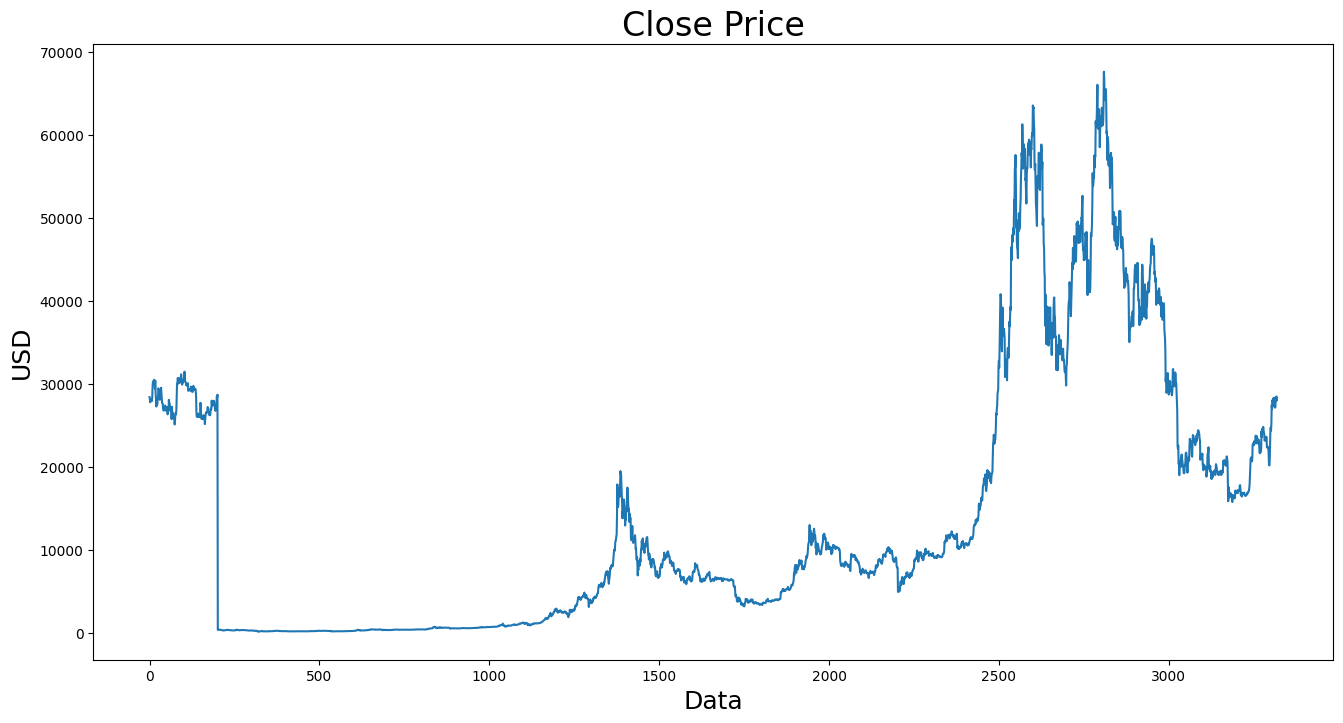

In [ ]:
plt.figure(figsize=(16,8))
plt.title('Close Price', fontsize=24)
plt.plot(df['Close'])
plt.xlabel('Data', fontsize=18)
plt.ylabel('USD', fontsize=18)
plt.show()

So as we want to work only with Close Price, let's use .filter method. then we will import the values of the close price column in data variable to dataset variable.

In [ ]:
#Creat a new dataframe with only Close Price
data = df.filter(['Close'])
#Convert the dataframe to numpy array
dataset = data.values
# Get the number of rows to train the model on. we need this number to create our train and test sets
# math.ceil will round up the number
training_data_len = math.ceil(len(dataset) * .8) # We are using %80 of the data for training
training_data_len

2656

Now that we have our close price values in a seprated dataframe we can start normalization our data.

In [ ]:
# Scale the data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)
scaled_data
     

array([[0.41895632],
       [0.41581445],
       [0.40974388],
       ...,
       [0.4133549 ],
       [0.41995722],
       [0.41333449]])

# 🪓 Splitting test_data and train_data

In this case, we can't use train_test_split function, because we need our train and test sets to be Sequential Data. LSTM network needs to have the last output values of network layer for the input of the next layer of network. So we can't use train_test_split and randomize our train/test data.

Our model will predict the price by looking the last 60 days of price. this will help our model to predict a better price and not just a random number that would have less than %50 accuracy.

In [ ]:
# Creat the training dataset
train_data = scaled_data[0:training_data_len, :]
# Split the data into X_train and y_train data sets
X_train = []
y_train = []

for i in range(60, len(train_data)):
  X_train.append(train_data[i-60: i, 0])
  y_train.append(train_data[i, 0])


  if i <= 60:
    print(X_train)
    print(y_train)
    print()

[array([0.41895632, 0.41581445, 0.40974388, 0.41535119, 0.41549801,
       0.41351187, 0.41175666, 0.41208217, 0.41779909, 0.43738589,
       0.44602351, 0.44459885, 0.44845727, 0.44974283, 0.44726166,
       0.44721506, 0.43430028, 0.4484348 , 0.42506483, 0.41650714,
       0.40212672, 0.41014869, 0.4067933 , 0.40581324, 0.41742138,
       0.41912943, 0.43472679, 0.43274537, 0.43138352, 0.43168503,
       0.41421566, 0.42295553, 0.42778975, 0.42543627, 0.43562601,
       0.42628081, 0.41960841, 0.40832009, 0.40779333, 0.40724398,
       0.39802928, 0.39512377, 0.39481345, 0.3969883 , 0.40087701,
       0.39856144, 0.40393552, 0.39552768, 0.39638717, 0.39994054,
       0.39436453, 0.39581064, 0.40136719, 0.38814676, 0.39024487,
       0.39385206, 0.39606404, 0.41412779, 0.40908597, 0.40843994])]
[0.4012771446503869]



In [ ]:
len(X_train)

2596

So now X_train has 2083 array which any of them contains 60 days of price in them and y_train contains 2083 days of price which is the price of the last 60 days.

LSTM model needs the data to be an array. So here we will convert X_train and y_train to an array list.

In [ ]:
# Convert the X_train and y_train to numpy array
X_train, y_train = np.array(X_train), np.array(y_train)

In [ ]:
X_train.shape

(2596, 60)

By the way, LSTM needs the data to be inputet by 3 dimension. So we will reshape X_train to a 3-dim array

In [ ]:
# Reshape the data because LSTM needs 3 dim
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1)) # we make it like pros. it wanna say "np.reshape(X_train, (2083, 60, 1))"
X_train.shape
     

(2596, 60, 1)

Now that we finish creating our train data, we can create our test data (Just like how we did with train data).

In [ ]:
# Create the testing dataset
# Create a new array containing scaled values from index 2083
test_data = scaled_data[training_data_len - 60 : , :]

#Create the data sets X_test and y_test
X_test = []
y_test = dataset[training_data_len : , :]
for i in range(60, len(test_data)):
  X_test.append(test_data[i-60 : i, 0])


In [ ]:
# Convert the data to a numpy array 
X_test = np.array(X_test)

In [ ]:
# Reshape the test data
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
     

# 🤖 Model Building

Here we getting to the fun part, Creating the model

We are using 2 layers of LSTM and 2 layers of Dense. Our first LSTM layer has return_sequence=True because our first and second layers are LSTM and we have to pass the output of the first layer to the second layer. (Again: LSTM is a Network for Sequential Data)

Our last layer only has one unit in it while we need only one number (one price) to predict.

In [ ]:
# Build LSTM model
tf.random.set_seed(42)

model_1 = Sequential()
model_1.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1))) # we made it like pros ;) , the simple form is "input_shape(60, 1)""
model_1.add(LSTM(50, return_sequences=False))
model_1.add(Dense(25))
model_1.add(Dense(1))
     

2024-02-18 05:34:49.592096: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2024-02-18 05:34:49.592123: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2024-02-18 05:34:49.592144: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (p-96d97d61-5c57-47b1-a951-d6738584d181): /proc/driver/nvidia/version does not exist
2024-02-18 05:34:49.592390: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropria

In [ ]:
# Compile the model
model_1.compile(optimizer='adam', loss='mse')
     

We will store the steps of each epochs in history variable. We are doing this to ploting the loss and finding the best number of epochs to avoid overfiting training.

Here we make a variable call callback which has the job to stop training the model whenever the loss is no longer decreasing.

In [ ]:
# Train the model
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=2)
history = model_1.fit(X_train, y_train, batch_size=1, epochs=10)

Epoch 1/10
2596/2596 [==============================] - 140s 52ms/step - loss: 0.0014
Epoch 2/10
2596/2596 [==============================] - 140s 54ms/step - loss: 7.1250e-04
Epoch 3/10
2596/2596 [==============================] - 137s 53ms/step - loss: 5.7850e-04
Epoch 4/10
2596/2596 [==============================] - 134s 52ms/step - loss: 4.1505e-04
Epoch 5/10
2596/2596 [==============================] - 137s 53ms/step - loss: 4.0692e-04
Epoch 6/10
2596/2596 [==============================] - 144s 55ms/step - loss: 3.5972e-04
Epoch 7/10
2596/2596 [==============================] - 142s 55ms/step - loss: 3.5652e-04
Epoch 8/10
2596/2596 [==============================] - 140s 54ms/step - loss: 3.7841e-04
Epoch 9/10
2596/2596 [==============================] - 142s 55ms/step - loss: 3.0562e-04
Epoch 10/10
2596/2596 [==============================] - 142s 55ms/step - loss: 3.2453e-04


In [ ]:
# Get the model_1 predicted price values 
predictions_1 = model_1.predict(X_test)
predictions_1 = scaler.inverse_transform(predictions_1)
len(predictions_1)

21/21 [==============================] - 2s 29ms/step


663

In [ ]:
# Get the root mean squared error (RMSE) for model_1
rmse = np.sqrt(np.mean(predictions_1 - y_test)**2)
rmse

576.1136105194191

# 🧑🏻‍🎓 Learning curve

Text(0.5, 0, 'epochs')

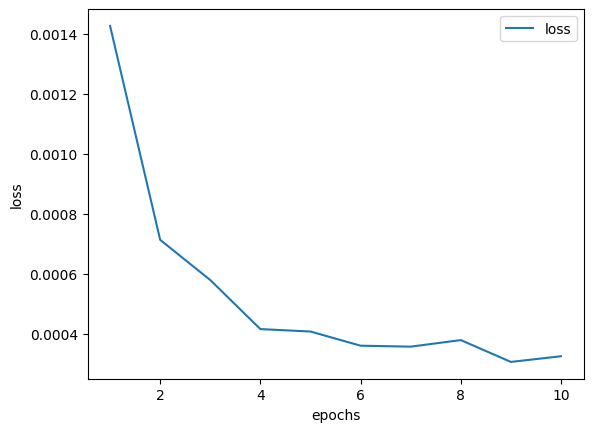

In [ ]:
# Let's plot the history of model_1 and see what's going on
historyForPlot = pd.DataFrame(history.history)
historyForPlot.index += 1 # we plus 1 to the number of indexing so our epochs Plot picture will be counting from 1 not 0.
historyForPlot.plot()
plt.ylabel("loss")
plt.xlabel("epochs")

In [ ]:
# Train the model again with 7 epochs
# but first we need to create another model so we can compare them together

# building LSTM model_2
tf.random.set_seed(42)

model_2 = Sequential()
model_2.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1))) # we made it like pros ;) | the simple form is "input_shape(60, 1)
model_2.add(LSTM(50, return_sequences=False))
model_2.add(Dense(25))
model_2.add(Dense(1))

# Compile model_2
model_2.compile(optimizer='Adam', loss='mse')

# Fit model_2
history_2 = model_2.fit(X_train, y_train, batch_size=1, epochs=6)

Epoch 1/6
2596/2596 [==============================] - 147s 55ms/step - loss: 0.0016
Epoch 2/6
2596/2596 [==============================] - 147s 57ms/step - loss: 7.4963e-04
Epoch 3/6
2596/2596 [==============================] - 144s 56ms/step - loss: 5.6676e-04
Epoch 4/6
2596/2596 [==============================] - 149s 57ms/step - loss: 4.1507e-04
Epoch 5/6
2596/2596 [==============================] - 150s 58ms/step - loss: 4.1745e-04
Epoch 6/6
2596/2596 [==============================] - 151s 58ms/step - loss: 3.5976e-04


In [ ]:
# Get the model_2 predicted price values 
predictions_2 = model_2.predict(X_test)
predictions_2 = scaler.inverse_transform(predictions_2)
len(predictions_2)

21/21 [==============================] - 2s 34ms/step


663

# 📉 Model Evaluation

In [ ]:
# Get the root mean squared error (RMSE) for model_2
rmse_2 = np.sqrt(np.mean(predictions_2 - y_test)**2)
rmse_2

314.71628201451756

/tmp/ipykernel_863/1864770563.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_1['Predictions'] = predictions_1
/tmp/ipykernel_863/1864770563.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_2['Predictions'] = predictions_2


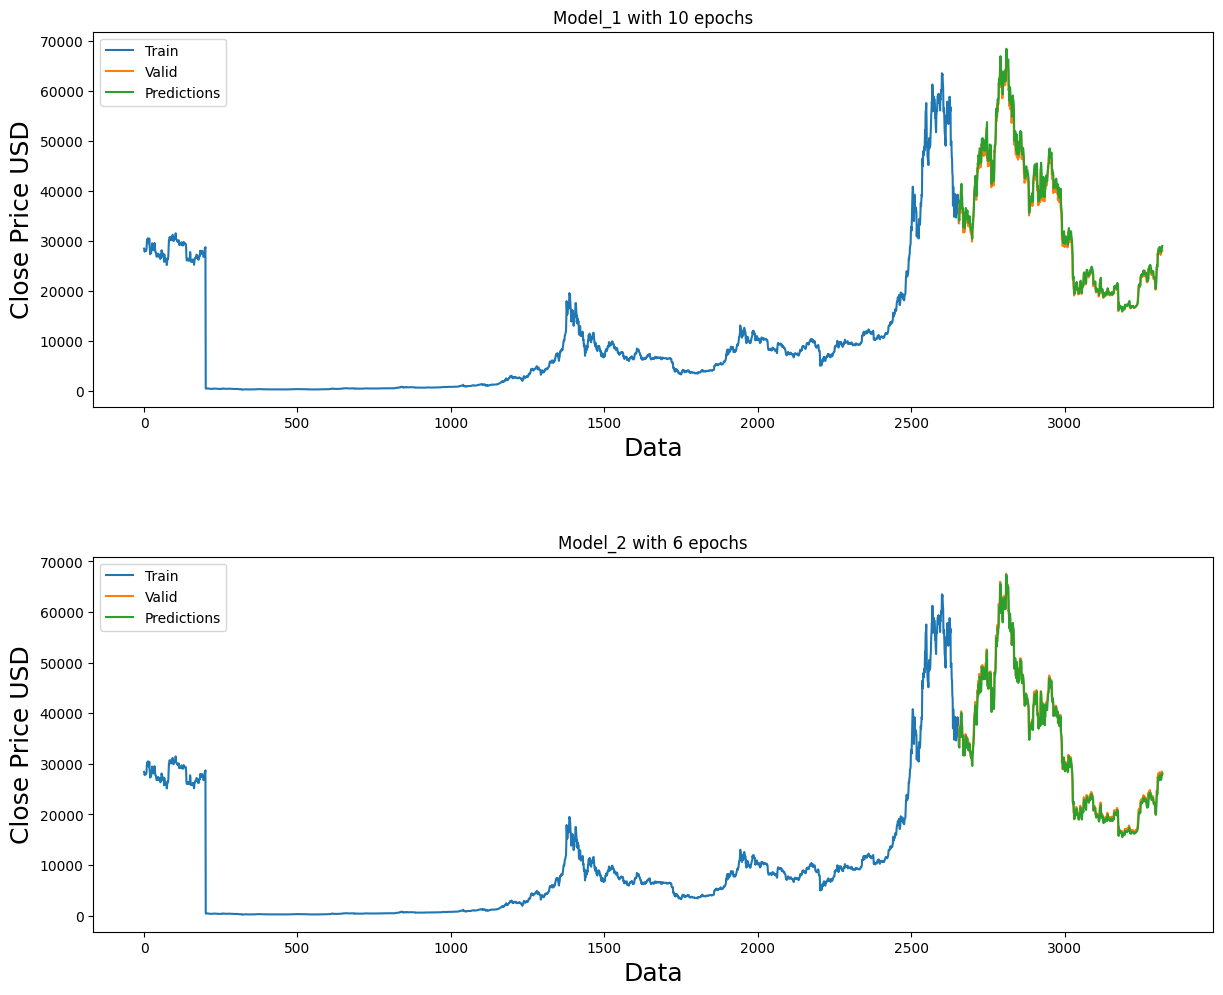

In [ ]:
# Plot the data
train = data[:training_data_len]

#data for model_1
valid_1 = data[training_data_len:]
valid_1['Predictions'] = predictions_1

# data for model_2
valid_2 = data[training_data_len:]
valid_2['Predictions'] = predictions_2

# Visualized the data 
#model_1
plt.figure(figsize=(14, 10))
plt.subplot(2, 1, 1)
plt.title('Model_1 with 10 epochs')
plt.xlabel('Data', fontsize=18)
plt.ylabel('Close Price USD', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid_1[['Close', 'Predictions']])

plt.legend(['Train', 'Valid', 'Predictions'], loc='upper left')

#model_2
plt.subplot(2, 1, 2)
plt.title('Model_2 with 6 epochs')
plt.xlabel('Data', fontsize=18)
plt.ylabel('Close Price USD', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid_2[['Close', 'Predictions']])

plt.legend(['Train', 'Valid', 'Predictions'], loc='upper left')

plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=1, 
                    wspace=0.4, 
                    hspace=0.4)
plt.show()
     


In [ ]:
#Get the last 60 day closing price values and convert the datadrame to an array
last_60_days = data[-60:].values
# Scale the data to be values between 0 and 1
last_60_days_scaled = scaler.fit_transform(last_60_days)
# create an empty list
new_X_test = []
# Append the past 60 days
new_X_test.append(last_60_days_scaled)
# Convert the X_test data set to a numpy array
new_X_test = np.array(new_X_test)
# Reshape the data 
new_X_test = np.reshape(new_X_test, (new_X_test.shape[0], new_X_test.shape[1], 1))
# Get the predicted scaled price
pred_price = model_1.predict(new_X_test)
# Undo the scaling
pred_price = scaler.inverse_transform(pred_price)
print(pred_price)

1/1 [==============================] - 0s 402ms/step
[[28165.33]]


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=96d97d61-5c57-47b1-a951-d6738584d181' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>